# Table of Contents

* Introduction
* Data Wrangling
    1. Discovering
    2. Structuring
    3. Cleaning
    4. Enriching
    5. Validating
    6. Publishing
* Probability
* A/B Test
    1. Hypothesis test
    2. Regression
* Conclusions
    1. Results
    2. Limitations

# Introduction

For this project, you will be working to understand the results of an A/B test run by an e-commerce website. Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plot_assist import *
import statsmodels.api as sm
import random
random.seed(42)

we have two dataframes intersected at `user_id` feature so we are going to merge them befor doing any data wrangling

# Data Wrangling
## 1. Discovering

In [2]:
df = pd.read_csv('data/ab_data.csv')
df.shape
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
print(f'No. rows: {df.shape[0]} \nNo. columns: {df.shape[1]}')

No. rows: 294478 
No. columns: 5


In [4]:
descrip_column(df['user_id'])

name: user_id
dtype: int64
null count: 0
unique: [851104 804228 661590 ... 734608 697314 715931]
unique count: 290584
max range: 945999
min range: 630000
max frequncy: 2
min frequncy: 1


we notice here multiple points :
* total number of unique users is 290584
* there are repeated user ids with max repetitive 2
* this column has no missing values

In [5]:
descrip_column(df['timestamp'])

name: timestamp
dtype: object
null count: 0
unique: ['2017-01-21 22:11:48.556739' '2017-01-12 08:01:45.159739'
 '2017-01-11 16:55:06.154213' ... '2017-01-22 11:45:03.439544'
 '2017-01-15 01:20:28.957438' '2017-01-16 12:40:24.467417']
unique count: 294478
max frequncy: 1
min frequncy: 1


* this variable type is quantitative continuous with seconds as threshold but it can be discrete by segregating it into years, monthes, days and hours , neglecting minutes and seconds as it will not really affect our analysis.
* this column has no missing values

In [6]:
descrip_column(df['group'])

name: group
dtype: object
null count: 0
unique: ['control' 'treatment']
unique count: 2
max frequncy: 147276
min frequncy: 147202


* there are only two unique groups control and treatment.
* this column has no missing values.

In [7]:
descrip_column(df['landing_page'])

name: landing_page
dtype: object
null count: 0
unique: ['old_page' 'new_page']
unique count: 2
max frequncy: 147239
min frequncy: 147239


* there are only two unique landing pages, old page and new page.
* this column has no missing values.

In [8]:
descrip_column(df['converted'])

name: converted
dtype: int64
null count: 0
unique: [0 1]
unique count: 2
max range: 1
min range: 0
max frequncy: 259241
min frequncy: 35237


* there are only two unique converted status, 0 for False and 1 for True.
* this column has no missing values.

## 2. Structuring

we gonna segregating `timestamp` column into years, monthes, days and hours , neglecting minutes and seconds as mentioned in the previous step

In [9]:
datetime = pd.to_datetime(df['timestamp'])
df['timestamp_year'] = datetime.dt.year
df['timestamp_month'] = datetime.dt.month
df['timestamp_day'] = datetime.dt.day
df['timestamp_hour'] = datetime.dt.hour
df.head()

,user_id,timestamp,group,landing_page,converted,timestamp_year,timestamp_month,timestamp_day,timestamp_hour
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017,1,21,22
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017,1,12,8
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017,1,11,16
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017,1,8,18
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017,1,21,1


## 3. Cleaning

first we gonna drop `timestamp` column as it will no longer be needed

In [10]:
df.drop(['timestamp'], axis=1, inplace=True)

now we gonna check for the number of times the `new_page` and `treatment` don't match

In [11]:
table = df.groupby('group')['landing_page'].value_counts().unstack()
table

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [12]:
mismatch_count = table['old_page']['treatment'] + table['new_page']['control']
print(f'the number of times the `new_page` and `treatment` do not match is {mismatch_count}')

the number of times the `new_page` and `treatment` do not match is 3893


as we cannot be sure if the mismatched rows are truly received the new or old page. we gonna drop These rows

In [13]:
idx1 = (df['group'] == 'control') & (df['landing_page'] == 'old_page')
idx2 = (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')
df = df[idx1 | idx2].copy()

now we gonna check that the mismatched rows are removed

In [14]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

0

now we gonna handle repeated user ids

In [15]:
mask = df['user_id'].value_counts()
non_unique = mask[mask > 1].index[0]
df[df['user_id'] == non_unique]

,user_id,group,landing_page,converted,timestamp_year,timestamp_month,timestamp_day,timestamp_hour
1899,773192,treatment,new_page,0,2017,1,9,5
2893,773192,treatment,new_page,0,2017,1,14,2


seems like we have only one repaeted id which is 773192.

now so we gonna drop one of the rows with the duplicate id

In [16]:
df.drop_duplicates(subset=['user_id'],inplace=True)

we gonna check again for duplicate user_id

In [17]:
df.duplicated(['user_id'], keep=False).sum()

0

sounds about right

now we gonna check for duplicate rows in general

In [18]:
df.duplicated().sum()

0

seems like our dataset is clean

## 4. Enriching

in this step we are going to enrich our dataset with accompanied dataset

In [19]:
df2 = pd.read_csv('data/countries.csv')
df2.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [20]:
descrip_column(df2['user_id'])

name: user_id
dtype: int64
null count: 0
unique: [834778 928468 822059 ... 799368 655535 934996]
unique count: 290584
max range: 945999
min range: 630000
max frequncy: 1
min frequncy: 1


seems like we have the same unique user_id count as the primary dataset, hopefully we gonna get completely matched ids or we will have null values otherwise.

In [21]:
descrip_column(df2['country'])

name: country
dtype: object
null count: 0
unique: ['UK' 'US' 'CA']
unique count: 3
max frequncy: 203619
min frequncy: 14499


* we have three unique countries, United Kingdom 'UK', United States 'US' and Canada 'CA'
* this column has no missing values

now we gonna merge the two dataset on the intersection column 'user_id' with making our primary dataset as base.

In [22]:
df = pd.merge(left=df, right=df2, how='left', left_on='user_id', right_on='user_id')
df.head()

,user_id,group,landing_page,converted,timestamp_year,timestamp_month,timestamp_day,timestamp_hour,country
0,851104,control,old_page,0,2017,1,21,22,US
1,804228,control,old_page,0,2017,1,12,8,US
2,661590,treatment,new_page,0,2017,1,11,16,US
3,853541,treatment,new_page,0,2017,1,8,18,US
4,864975,control,old_page,1,2017,1,21,1,US


now we gonna check for any missing values in the new column.

In [23]:
df['country'].isnull().any()

False

the accompanied dataset user ids are perfectly matching the user ids in the primary dataset

## 5. Validating

we gonna skip this step as no need for Validation

## 6. Publishing

now that everything is set we are ready to save our data.

In [24]:
df.to_csv('data/ab_data_clean.csv', index=False)

# Probability

* e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

## What is the probability of an individual converting regardless of the page they receive?

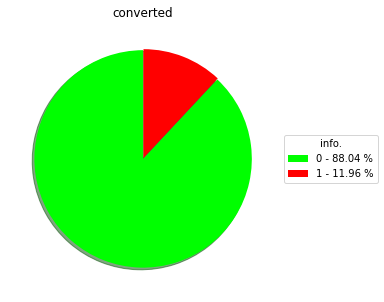

In [25]:
pie_plot(df['converted'])

here we can notic the proportion of individual converting is 11.96% and the proportion of individual not converting is 88.04%

## Given that an individual was in the control group - treatment group, what is the probability they converted?

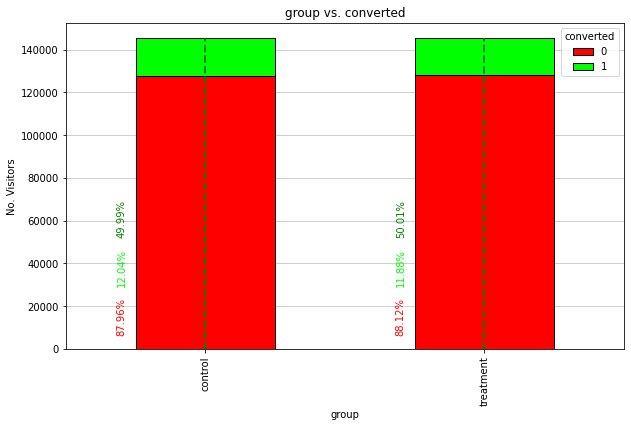

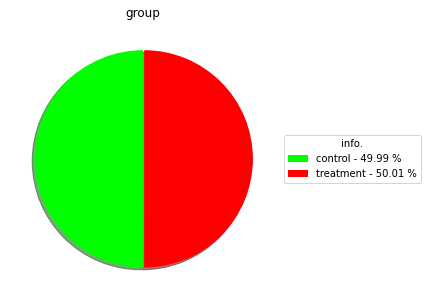

In [26]:
bar_plot(df,'group','converted',ylabel='No. Visitors')
pie_plot(df['group'])

* the probability of an individual converted given that they in the control group is 12.04%
* the probability of an individual converted given that they in the treatment group is 11.88%

In [27]:
temp  = df.groupby('converted')['group'].value_counts().unstack()
temp

group,control,treatment
converted,,
0,127785,128046
1,17489,17264


## What is the probability that an individual received the new page - old page?

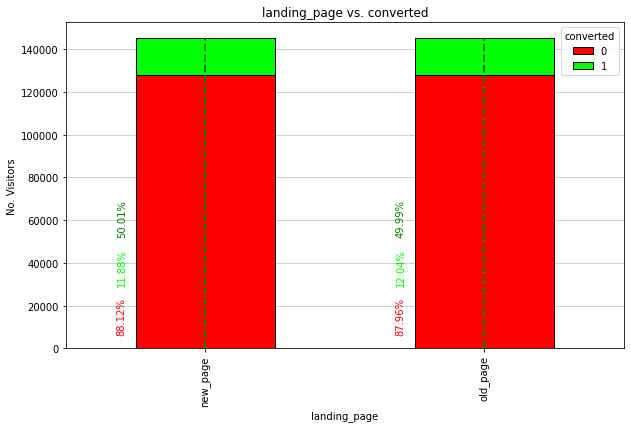

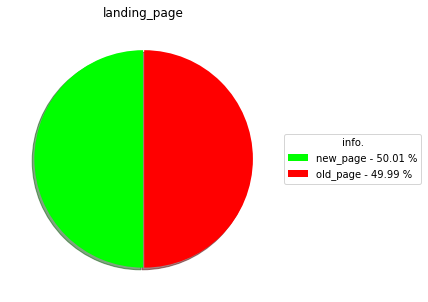

In [28]:
bar_plot(df,'landing_page','converted',ylabel='No. Visitors')
pie_plot(df['landing_page'])

* the probability that an individual received the new page is 50.01%
* the probability that an individual received the old page is 49.99%

## is timestamp year, month, day or hour associated with convertion rate ?

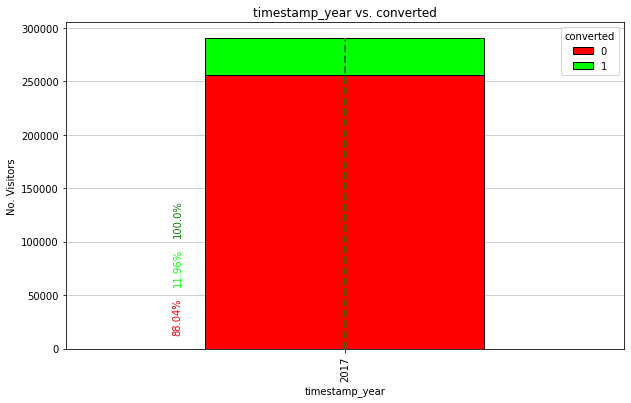

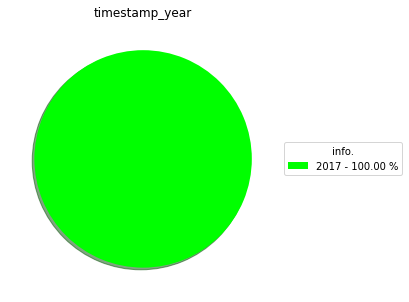

In [29]:
bar_plot(df,'timestamp_year','converted',ylabel='No. Visitors')
pie_plot(df['timestamp_year'])

not much we can coclude from this plot but now we know that the experiment has run during the year 2017

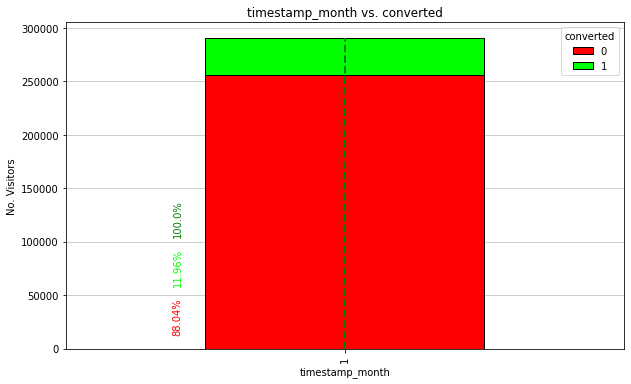

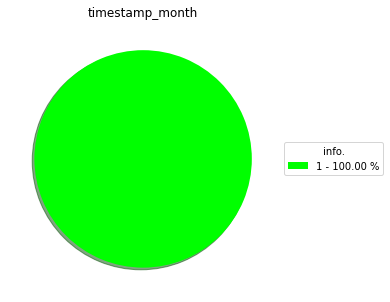

In [30]:
bar_plot(df,'timestamp_month','converted',ylabel='No. Visitors')
pie_plot(df['timestamp_month'])

same as the previous plot we can conclude that the experiment has run during the 1st month

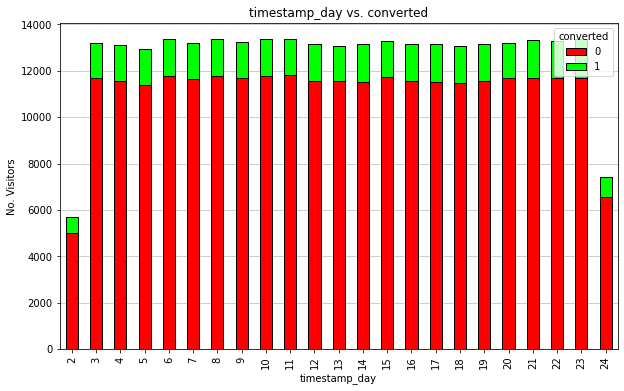

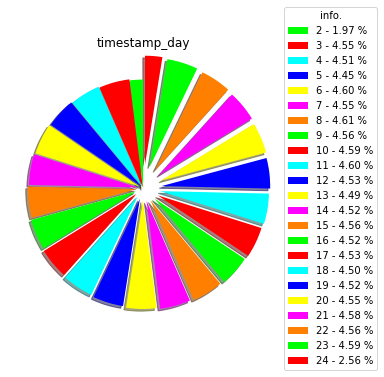

In [31]:
bar_plot(df,'timestamp_day','converted',ylabel='No. Visitors',percentages=False)
pie_plot(df['timestamp_day'])

In [32]:
Proportion(df,'timestamp_day','converted')

converted,0,1,total
timestamp_day,,,
2,87.73,12.27,1.97
3,88.62,11.38,4.55
4,88.07,11.93,4.51
5,88.09,11.91,4.45
6,88.06,11.94,4.60
7,88.14,11.86,4.55
8,88.02,11.98,4.61
9,88.11,11.89,4.56
10,88.04,11.96,4.59


* the experiment has run for 23 days from the 2nd day of the month to the 24th.
* the traffic is the almost the same for all days but the first and the last day of the experiment are the least crowded.
* we can notic that convertion rate is approximately the same for all days that concludes that timestamp day doesn't affect convertion rate.

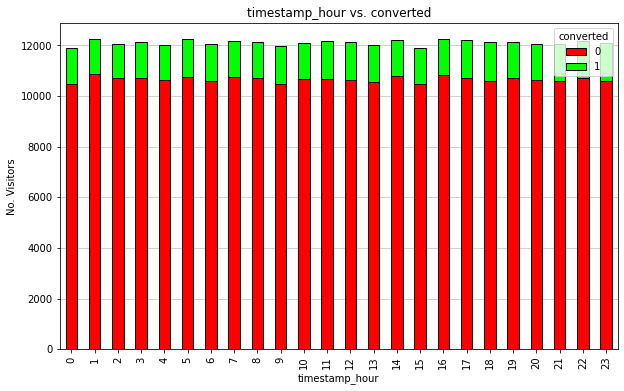

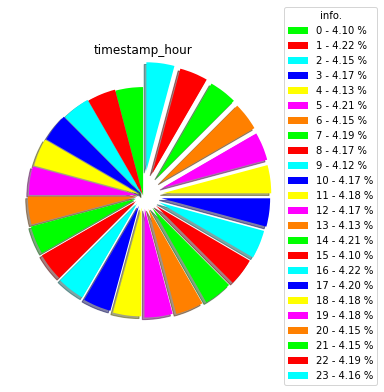

In [33]:
bar_plot(df,'timestamp_hour','converted',ylabel='No. Visitors',percentages=False)
pie_plot(df['timestamp_hour'])

In [34]:
Proportion(df,'timestamp_hour','converted')

converted,0,1,total
timestamp_hour,,,
0,87.97,12.03,4.10
1,88.63,11.37,4.22
2,88.67,11.33,4.15
3,88.50,11.50,4.17
4,88.59,11.41,4.13
5,87.91,12.09,4.21
6,87.87,12.13,4.15
7,88.24,11.76,4.19
8,88.15,11.85,4.17


* the experiment has run for 24 hour a day.
* the traffic is the almost the same for all hours.
* we can notic that convertion rate is approximately the same for all hours that concludes that timestamp hour doesn't affect convertion rate.

## is country associated with convertion rate ?

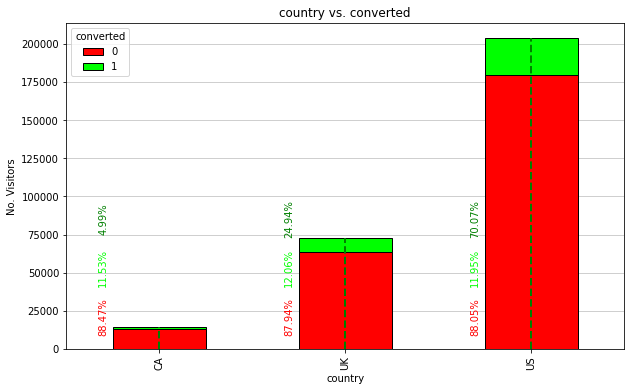

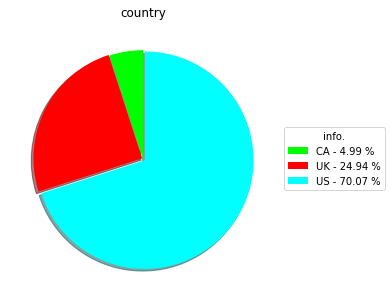

In [35]:
bar_plot(df,'country','converted',ylabel='No. Visitors')
pie_plot(df['country'])

* we notic that most of samples were from the US then the UK then Canada.
* although there a huge difference in the number of samples proportions from each country the convertion rate is approximately the same for all countries. that concludes that country does not affect convertion rate.

# A/B Test

## 1. Hypothesis test
assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

we can write the hypothesis to be

$$H_0: p_{new} \leq p_{old}$$

$$H_1: p_{new} > p_{old}$$

with equation rearrangement it can be

$$H_0: p_{new} - p_{old} \leq 0$$

$$H_1: p_{new} - p_{old} > 0$$

here the hypothesis question is: is the conversion rate for new page is greater (better) than old page ?

## What is the conversion rate for $p_{new}$, $p_{old}$ under the null?

first we gonna calculate conversion rates for $p_{new}$, $p_{old}$ under the null hypothesis.

Under the null hypothesis, there is no difference in the success rates so p_new equals p_old

In [36]:
p_new = p_old = df['converted'].mean()
p_new,p_old

(0.11959708724499628, 0.11959708724499628)

## What is $n_{new}$, the number of individuals in the treatment group?

In [37]:
n_new = (df['group'] == 'treatment').sum()
n_new

145310

## What is $n_{old}$, the number of individuals in the control group?

In [38]:
n_old = (df['group'] == 'control').sum()
n_old

145274

## Simulate $n_{new}$, $n_{old}$ transactions with a conversion rate of $p_{new}$, $p_{old}$ respectively under the null. Store these in `new_page_converted`, `old_page_converted` respectively and find $p_{new}$ - $p_{old}$

In [39]:
new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, (1- p_new)]).mean()
old_page_converted = np.random.choice([1,0], size = n_old, p = [p_old, (1- p_old)]).mean()
p_diff = new_page_converted - old_page_converted
p_diff

0.00026642125177543663

## Store 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process in a NumPy array called `p_diffs`.

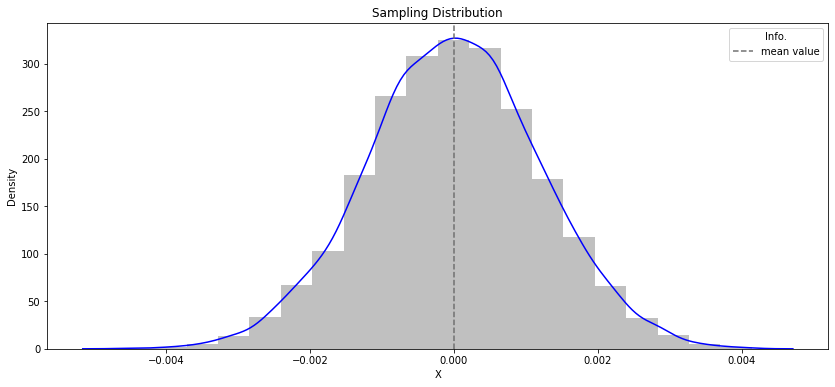

In [41]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, (1- p_new)]).mean()
    old_page_converted = np.random.choice([1,0], size = n_old, p = [p_old, (1- p_old)]).mean()
    p_diffs.append(new_page_converted - old_page_converted)
p_diffs = np.array(p_diffs)

plot_dist(p_diffs,color='#0000ff')

we can notice from the KDE curve that p_diffs (alternative hypothesis) sampling distribution is a normal distribution due to Central Limit Theorem

now we gonna simulate the null hypothesis by creating random normal distribution centered at 0 with the same standard deviation and size as the alternative hypothesis.

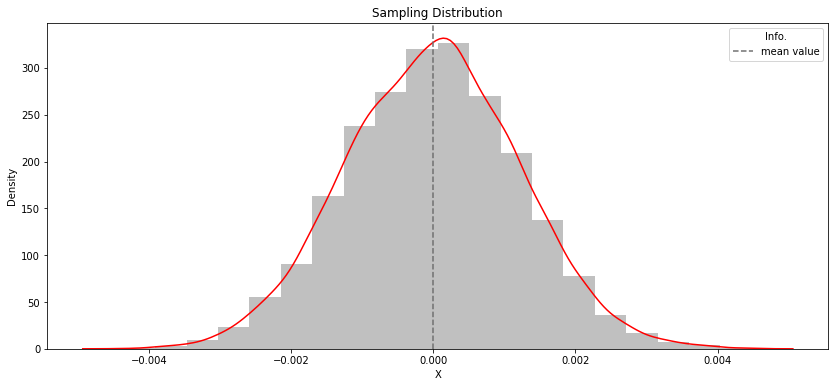

In [42]:
nullvals = np.random.normal(0,p_diffs.std(), 10000)
plot_dist(nullvals,color='#ff0000')

we can notice from the KDE curve that nullvals (null hypothesis) sampling distribution is a normal distribution due to Central Limit Theorem

now we gonna calculate p-value (Type I Error) and critical_val (actual difference)

In [43]:
critical_val = df[df['group'] == 'treatment']['converted'].mean() - df[df['group'] == 'control']['converted'].mean()
p_value = (nullvals > critical_val).mean()
p_value

0.9009

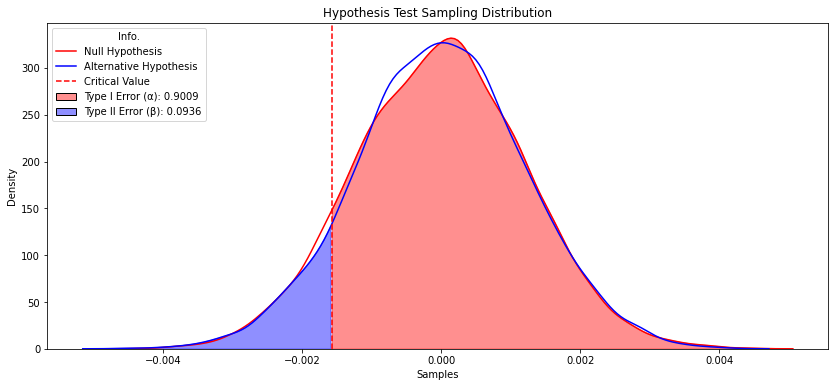

In [44]:
plot_Hypothesis(nullvals,p_diffs,critical_val)

note: the alpha on the plot is our p-value (Type I Error we about to commit) not our desired threshold which is 0.05 (Type I Error we ready to commit)

* the critical_val (actual difference) is negative that concludes that old page is slightly better than the new one.
* by comparing our p-value to our type I error threshold $\alpha$ (0.05) we conclude that the difference in conversion rate between new page and old page is not statistically significant, therefore we fail to reject the null hypothesis 

we can also implement our test using built-in function `stats.proportions_ztest` from statsmodels library

In [45]:
convert_new = df[df['group'] == 'treatment']['converted'].sum()
convert_old = df[df['group'] == 'control']['converted'].sum()
n_new = (df['group'] == 'treatment').sum()
n_old = (df['group'] == 'control').sum()
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


we can see that p-value here is approximately the same as the one we calculated earlier so our conclusion will remain the same.

> by comparing our p-value to our type I error threshold $\alpha$ (0.05) we conclude that the difference in conversion rate between new page and old page is not statistically significant, therefore we fail to reject the null hypothesis 

## 2. Regression

Since each row is either a conversion or no conversion, we gonna use logistic regression

in regression the null and alternative hypothesis are going to be
$$H_0: p_{new} = p_{old}$$
$$H_1: p_{new} \neq p_{old}$$

with rearrangement:

$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} \neq 0$$

here the hypothesis question is: is the conversion rate in new page differs from old page ?

In [46]:
new_df = df.copy()
new_df.head()

,user_id,group,landing_page,converted,timestamp_year,timestamp_month,timestamp_day,timestamp_hour,country
0,851104,control,old_page,0,2017,1,21,22,US
1,804228,control,old_page,0,2017,1,12,8,US
2,661590,treatment,new_page,0,2017,1,11,16,US
3,853541,treatment,new_page,0,2017,1,8,18,US
4,864975,control,old_page,1,2017,1,21,1,US


first we gonna preprocess our data by 0,1 encoding `country` and `group` columns plus
adding an `intercept` column.

In [47]:
new_df['intercept'] = 1
new_df[np.unique(new_df['group'].values)] = pd.get_dummies(new_df['group'])
new_df[np.unique(new_df['country'].values)] = pd.get_dummies(new_df['country'])
new_df.head()

,user_id,group,landing_page,converted,timestamp_year,timestamp_month,timestamp_day,timestamp_hour,country,intercept,control,treatment,CA,UK,US
0,851104,control,old_page,0,2017,1,21,22,US,1,1,0,0,0,1
1,804228,control,old_page,0,2017,1,12,8,US,1,1,0,0,0,1
2,661590,treatment,new_page,0,2017,1,11,16,US,1,0,1,0,0,1
3,853541,treatment,new_page,0,2017,1,8,18,US,1,0,1,0,0,1
4,864975,control,old_page,1,2017,1,21,1,US,1,1,0,0,0,1


now we gonna creat logistic regression model for each feature individually.
starting with `group` feature we gonna fit `treatment` only and drop `control` in order to make our matrix full rank.

In [48]:
model = sm.Logit(new_df['converted'], new_df[['intercept', 'treatment']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Jul 2021   Pseudo R-squ.:               8.077e-06
Time:                        01:40:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

from p-value (0.190) there is no statistically significant evidence that the conversion rate in new page differs from old page, hence we fail to reject the null hypothesis

In [49]:
np.exp(results.params)

intercept    0.136863
treatment    0.985123
dtype: float64

now from `country` feature we gonna fit `UK` and `US` only and drop `CA` in order to make our matrix full rank.

In [50]:
model = sm.Logit(new_df['converted'], new_df[['intercept', 'UK', 'US']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 30 Jul 2021   Pseudo R-squ.:               1.521e-05
Time:                        01:40:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

from p-values `UK` 0.074 and `US` 0.129 there is no statistically significant evidence that the conversion rate in new page differs from old page, hence we fail to reject the null hypothesis

In [51]:
np.exp(results.params)

intercept    0.130350
UK           1.052027
US           1.041647
dtype: float64

now we gonna fit `timestamp_hour` to regression model.

In [52]:
model = sm.Logit(new_df['converted'], new_df[['intercept','timestamp_hour']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Jul 2021   Pseudo R-squ.:               3.350e-05
Time:                        01:40:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                  0.007588
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -2.0217      0.011   -181.312      0.000      -2.044      -2.000
timestamp_hour     0.0022      0.001      2.670      0.008       0.001       0.004
==================================================================================
"""

from p-values 0.008 there is statistically significant evidence that the conversion rate in new page differs from old page, hence we should reject the null hypothesis

In [53]:
np.exp(results.params)

intercept         0.132427
timestamp_hour    1.002208
dtype: float64

now we gonna fit `timestamp_day` to regression model.

In [54]:
model = sm.Logit(new_df['converted'], new_df[['intercept','timestamp_day']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Jul 2021   Pseudo R-squ.:               1.000e-05
Time:                        01:40:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1446
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -2.0134      0.013   -153.778      0.000      -2.039      -1.988
timestamp_day     0.0013      0.001      1.459      0.145      -0.000       0.003
=================================================================================
"""

from p-values 0.145 there is no statistically significant evidence that the conversion rate in new page differs from old page, hence we fail to reject the null hypothesis

In [55]:
np.exp(results.params)

intercept        0.133533
timestamp_day    1.001312
dtype: float64

now we gonna creat model that combine the features we implemented individually eariler

In [56]:
model = sm.Logit(new_df['converted'], new_df[['intercept', 'treatment','timestamp_hour','timestamp_day', 'UK', 'US']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366096
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 30 Jul 2021   Pseudo R-squ.:               6.930e-05
Time:                        01:40:53   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.01151
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -2.0757      0.031    -67.201      0.000      -2.136      -2.015
treatment         -0.0149      0.011     -1.302      0.193      -0.037       0.008
timestamp_hour     0.0023      0.001      2.771      0.006       0.001       0.004
timestamp_day      0.0015      0.001      1.637      0.102      -0.000       0.003
UK                 0.0506      0.028      1.783      0.075      -0.005       0.106
US                 0.0406      0.027      1.509      0.131      -0.012       0.093
==================================================================================
"""

from p-values there is no statistically significant evidence that the conversion rate in new page differs from old page, hence we fail to reject the null hypothesis

In [57]:
np.exp(results.params)

intercept         0.125469
treatment         0.985222
timestamp_hour    1.002297
timestamp_day     1.001475
UK                1.051927
US                1.041389
dtype: float64

# Conclusions
    
## 1. Results
* we found that convertion rate of old page is slightly better than new page using different approaches.
* the results from almost all features (except `timestamp_hour`) shows no statistically significant evedence. therefor we failed to reject the null hypothesis.
## 2. Limitations
* the experiment duration is less than one month (23 days) maybe we can get different results if it run for longer duration.
* almost all of the variables are catigorial which prevents performing numerical or arithmetic operations or finding correlation between variables.
* there is variables that may really affect convertion rate such as: age of visitor, device used to access the website, gender of vistor (as interests differs ) and visitor cultural background which is not included.